## Analysis of model

This notebook will analyze the output of a trained model.

In [1]:
# preamble
import numpy as np
from dataloader import get_loader
from utils import train_anno, saliency
from models import UNet, MVCNN_Inception, MVCNN_VGG19, MVCNN_VGG19_early, MVCNN_Baseline, MVCNN_UNet
from torchvision.transforms import transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from IPython.display import clear_output
eps = 10e-16

Define model specifications.

In [2]:
repair_type = "001_hansson_pin_system"
batch_size = 12
id_ = 'baseline_22April18_1000_05'

Next up, we load the train and test data and the trained model.

In [3]:
idx = id_.find('_')
model_type = id_[:idx]
size = 224

transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((size,size)),
                                    ])
train_loader = get_loader(repair_type, split = 'train', batch_size=batch_size, transform = transform, num_workers=4)
test_loader = get_loader(repair_type, split = 'test', batch_size=batch_size, transform = transform, num_workers=4)

if model_type == 'baseline':
    model = MVCNN_Baseline()
checkpoint=torch.load('model_checkpoint_mvcnn_' + id_ + '.pth', map_location='cpu')
model.load_state_dict(checkpoint['state_dict'])
model.to(device)

Finished loading dataset.
Finished loading dataset.


MVCNN_Baseline(
  (convolutional): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1)

We show a couple of images with the true and the predicted score from the model both from the training and from the test data (this takes a while to run).

From train data


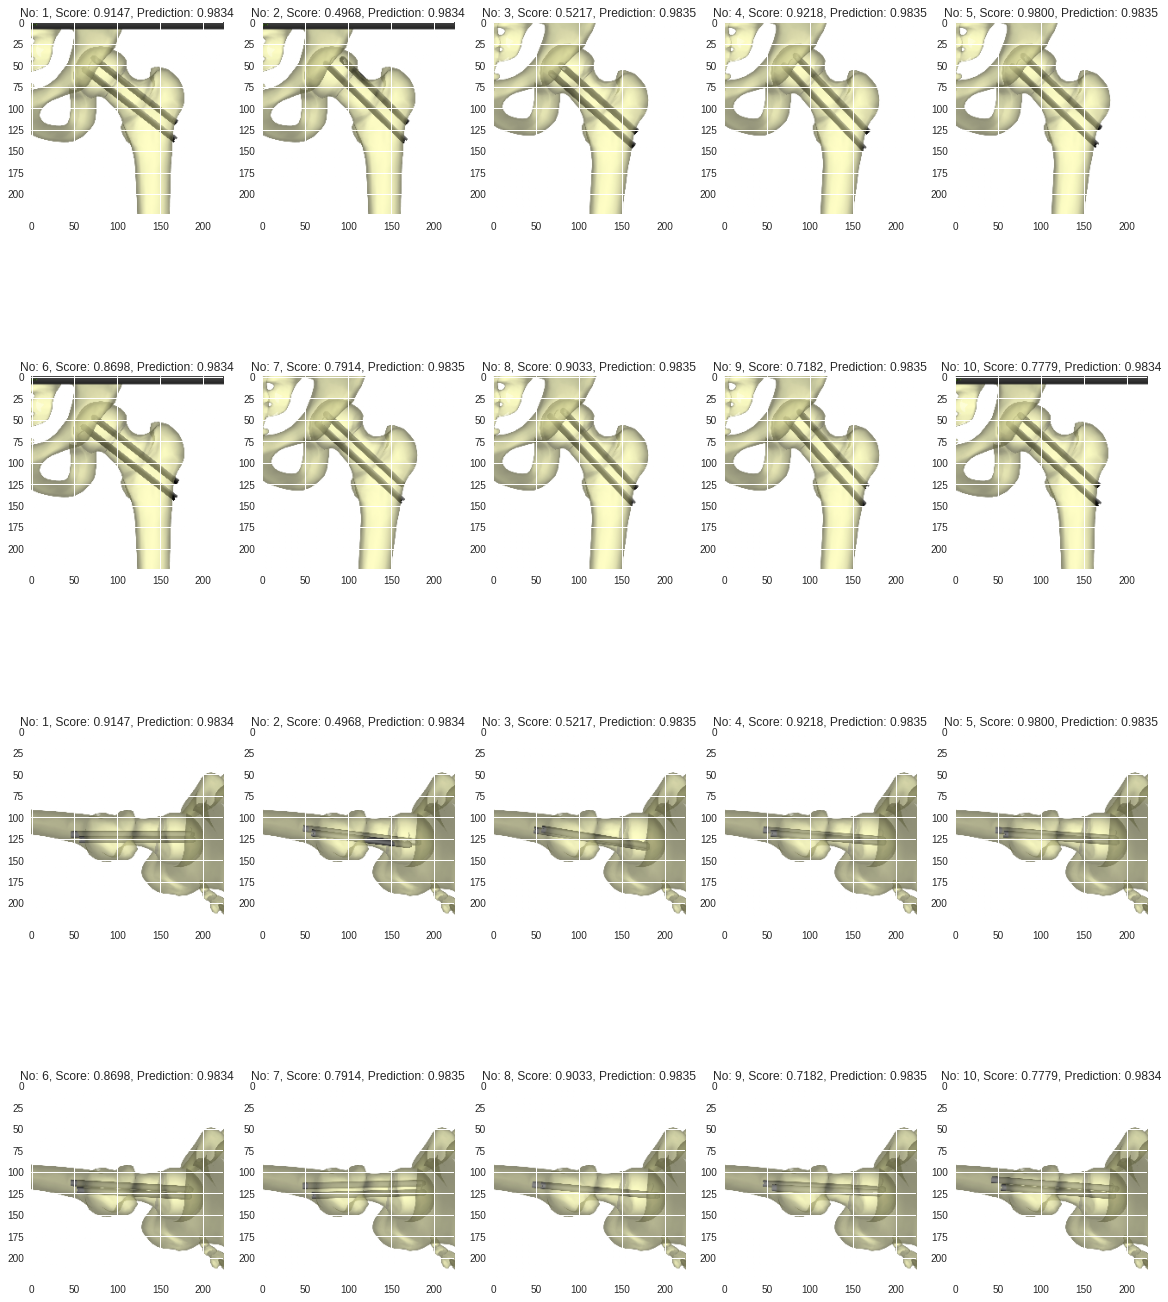

In [4]:
images_train, scores = next(iter(train_loader))
scores_train = scores #1-np.exp(scores)+eps # convert back from log scale
preds = model(images_train)
preds_train = 1-np.exp(preds.detach().numpy())+eps # convert back from log scale

num_images = 20

print('From train data')

plt.figure(figsize=(20,25))

for i in range(int(num_images/2)):
    plt.subplot(4,5,i+1)
    plt.imshow(images_train[i][:,0,:,:].permute(1, 2, 0), cmap = 'gray')
    plt.title("No: {:d}, Score: {:.4f}, Prediction: {:.4f}".format((i+1),scores_train[i].item(),preds_train[i].item()))

for i in range(int(num_images/2)):
    plt.subplot(4,5,int(num_images/2) + i+1)
    plt.imshow(images_train[i][:,1,:,:].permute(1, 2, 0), cmap = 'gray')
    plt.title("No: {:d}, Score: {:.4f}, Prediction: {:.4f}".format((i+1),scores_train[i].item(),preds_train[i].item()))

From test data


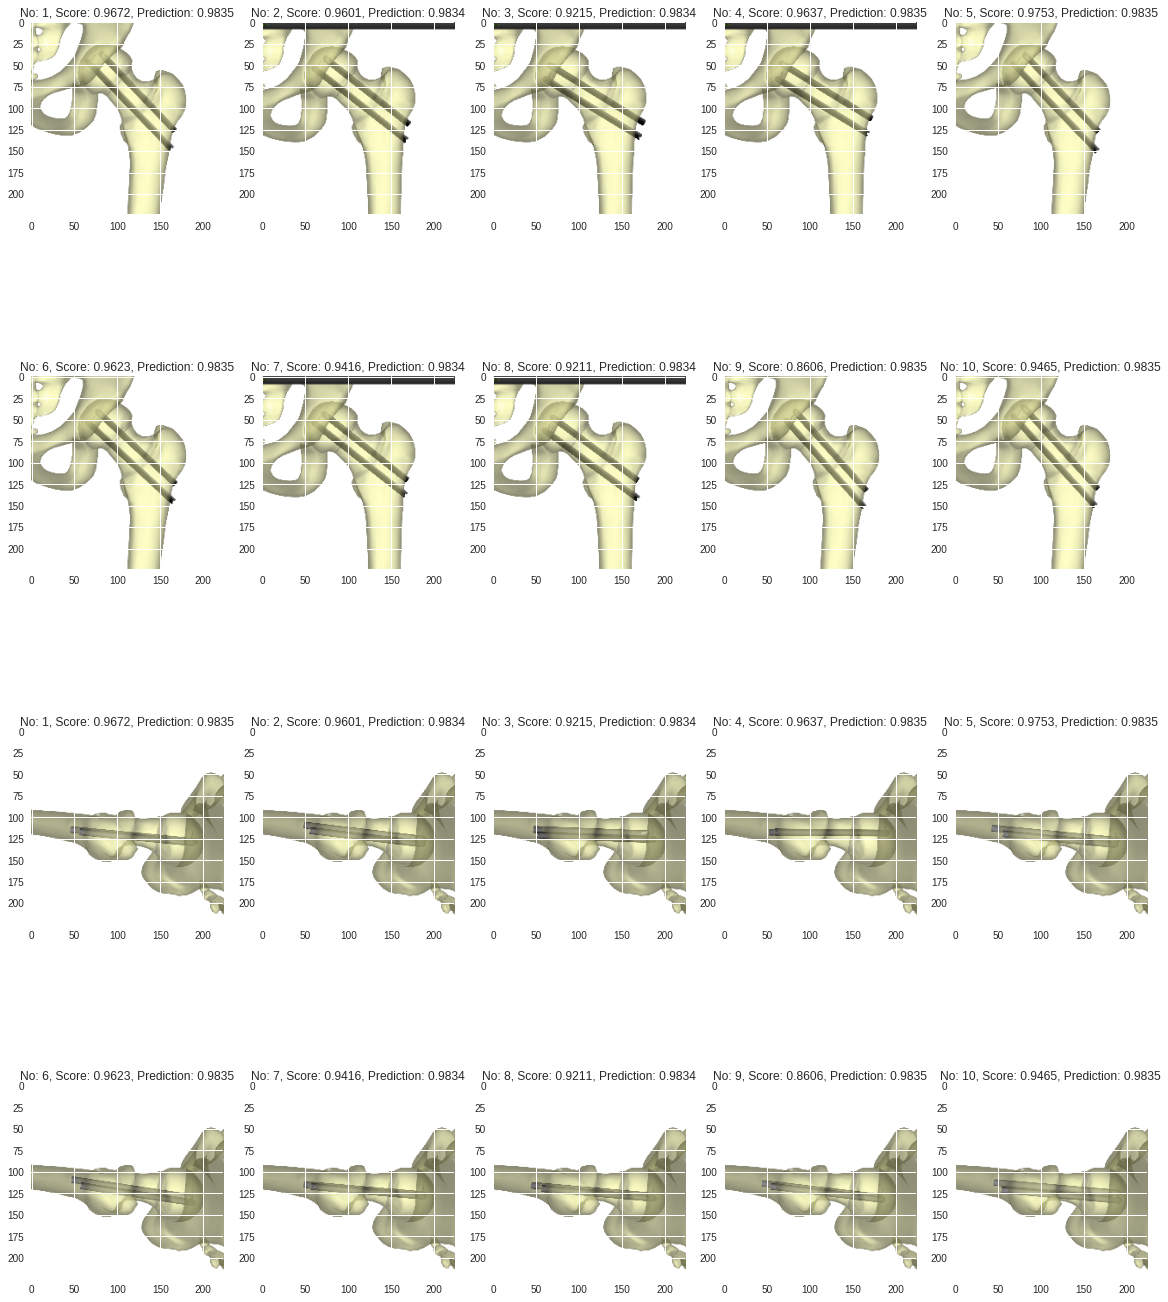

In [6]:
images_test, scores = next(iter(test_loader))
scores_test = scores #1-np.exp(scores)+eps # convert back from log scale
preds = model(images_test)
preds_test = 1-np.exp(preds.detach().numpy())+eps # convert back from log scale

num_images = 20

print('From test data')

plt.figure(figsize=(20,25))

for i in range(int(num_images/2)):
    plt.subplot(4,5,i+1)
    plt.imshow(images_test[i][:,0,:,:].permute(1, 2, 0), cmap = 'gray')
    plt.title("No: {:d}, Score: {:.4f}, Prediction: {:.4f}".format((i+1),scores_test[i].item(),preds_test[i].item()))

for i in range(int(num_images/2)):
    plt.subplot(4,5,int(num_images/2) + i+1)
    plt.imshow(images_test[i][:,1,:,:].permute(1, 2, 0), cmap = 'gray')
    plt.title("No: {:d}, Score: {:.4f}, Prediction: {:.4f}".format((i+1),scores_test[i].item(),preds_test[i].item()))

## Scores

Now, let's look into the scores a bit more. We'll start off by showing the predicted scores as a function of the true scores. Ideally, these will lie on a perfectly striaght line and thereby have a slope of 1 (this may take a while to run).

In [17]:
preds_train_all = []
scores_train_all = []
for k, (images, score) in enumerate(train_loader):
    print('Processed {:d}/{:d}'.format((k+1)*batch_size,len(train_loader.dataset)))
    scores_train_all += score.tolist()
    preds = model(images)
    preds_train_all += preds.detach().tolist()
    clear_output(wait=True)

preds_test_all = []
scores_test_all = []
for k, (images, score) in enumerate(test_loader):
    print('Processed {:d}/{:d}'.format((k+1)*batch_size,len(test_loader.dataset)))
    scores_test_all += score.tolist()
    preds = model(images)
    preds_test_all += preds.detach().tolist()
    clear_output(wait=True)

# convert back from log-scale
#scores_train_all = 1-np.exp(scores_train_all)+eps
preds_train_all = 1-np.exp(preds_train_all)+eps
#scores_test_all = 1-np.exp(scores_test_all)+eps
preds_test_all = 1-np.exp(preds_test_all)+eps

Iteration 360/349


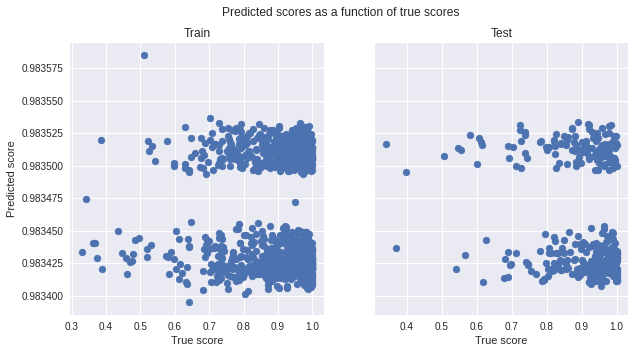

In [18]:
fig, axs = plt.subplots(1,2, figsize = (10,5), sharey = True)

fig.suptitle('Predicted scores as a function of true scores')
axs[0].scatter(scores_train_all, preds_train_all)
axs[0].set(title = 'Train', xlabel = 'True score', ylabel = 'Predicted score')
axs[1].scatter(scores_test_all, preds_test_all)
axs[1].set(title = 'Test', xlabel = 'True score')

plt.show()

### Scores vs. Saliency

By looking at the saliency maps, we can see the gradients in the input image. Thereby, we can see which pixels in the input image affects the score significantly.

In [19]:
idx = 10
image = images_test[idx]
score = scores_test[idx]
pred = preds_test[idx]
#_, model_slc = saliency(image, model)

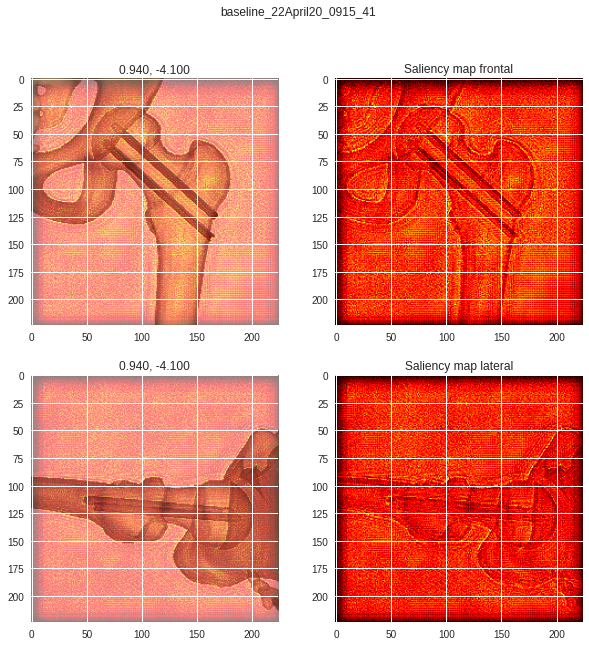

In [21]:
_, model_slc = saliency(image, model)

fig, ax = plt.subplots(2,2, figsize = (10,10))
fig.suptitle(id_)

ax[0,0].imshow(image.permute(1, 2, 3, 0)[0])
ax[0,0].set_title(f'{score.numpy():.3f}, {preds.item():.3f}')
ax[0,0].imshow(model_slc[0], cmap = plt.cm.hot, alpha = 0.5)

ax[0,1].set_title('Saliency map frontal')
ax[0,1].imshow(model_slc[0], cmap = plt.cm.hot)

ax[1,0].imshow(image.permute(1, 2, 3, 0)[1])
ax[1,0].set_title(f'{score.numpy():.3f}, {preds.item():.3f}')
ax[1,0].imshow(model_slc[1], cmap = plt.cm.hot, alpha = 0.5)

ax[1,1].set_title('Saliency map lateral')
ax[1,1].imshow(model_slc[1], cmap = plt.cm.hot)

plt.show()

In [22]:
print(scores_test)
print(preds_test)

tensor([0.9672, 0.9601, 0.9215, 0.9637, 0.9753, 0.9623, 0.9416, 0.9211, 0.8606,
        0.9465, 0.9396, 0.8234])
[[0.9835243 ]
 [0.9834219 ]
 [0.9834102 ]
 [0.98345345]
 [0.9835095 ]
 [0.98350704]
 [0.98344064]
 [0.98343706]
 [0.98352164]
 [0.98349696]
 [0.98351073]
 [0.9835154 ]]
